## DATA LOADING LIBRARY IMPORTS

In [1]:
import pandas as pd

## DATASET IMPORTS

In [172]:
df_sampled = pd.read_csv('sampled_players_df.csv')
df_sampled.drop(columns= 'Unnamed: 0', inplace=True)
threshold = df_sampled['adjusted_growth_rate'].quantile(0.75) ## Threshold to separate between classes
df_sampled['fast_learner'] = (df_sampled['adjusted_growth_rate'] > threshold).astype(int)
df_trend = pd.read_csv('trend_df.csv')
df = df_trend.merge(df_sampled[['player_id', 'fast_learner']], on='player_id') ##merging relevant columns
df.drop(columns='Unnamed: 0', inplace=True)
df = df.dropna()

## MODEL TRAINING

# Library Imports

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, RocCurveDisplay
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


# Only environnment features (engagement/spacing/challenge)

📊 Logistic Regression (Top 5 Features):
              precision    recall  f1-score   support

           0       0.80      0.60      0.68        65
           1       0.32      0.55      0.40        22

    accuracy                           0.59        87
   macro avg       0.56      0.57      0.54        87
weighted avg       0.67      0.59      0.61        87

ROC AUC: 0.592

🌲 Random Forest (SMOTE):
              precision    recall  f1-score   support

           0       0.76      0.80      0.78        65
           1       0.32      0.27      0.29        22

    accuracy                           0.67        87
   macro avg       0.54      0.54      0.54        87
weighted avg       0.65      0.67      0.66        87

ROC AUC: 0.520

📈 Summary:
                                      Accuracy  Precision  Recall  F1-Score  \
Logistic Regression (Top 5 Features)     0.586      0.316   0.545     0.400   
Random Forest (SMOTE)                    0.667      0.316   0.273     0.293   



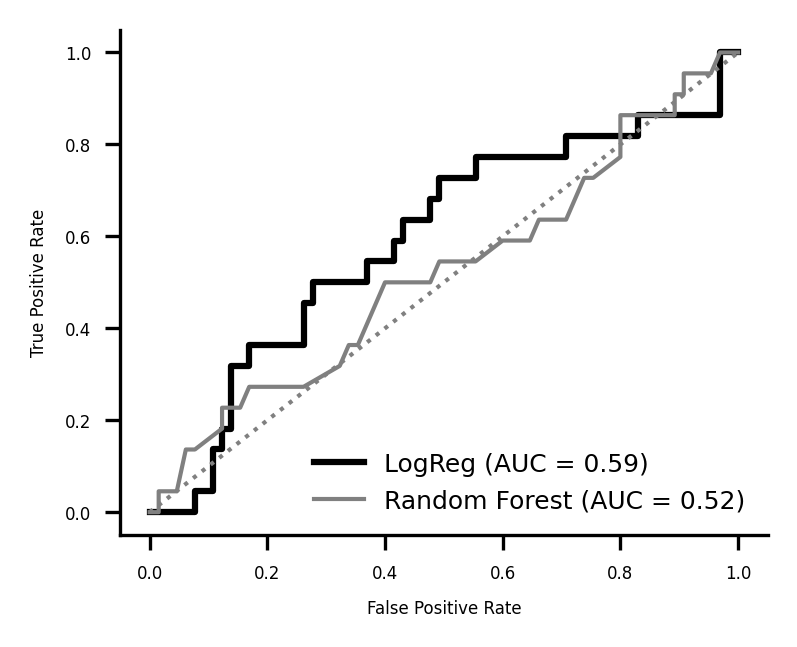

In [174]:
# -----------------------------
# Features & target definition
# -----------------------------
target = 'fast_learner'

practice_challenge_features = [
    'engagement__steady_magnitude', 'engagement__slope', 
    'engagement__early_slope', 'engagement__late_slope', 'engagement__mean', 'engagement__consistency',
    'spacing_weighted_mean_days_between_sessions__steady_magnitude', 'spacing_weighted_mean_days_between_sessions__slope', 
    'spacing_weighted_mean_days_between_sessions__early_slope', 'spacing_weighted_mean_days_between_sessions__late_slope', 
    'spacing_weighted_mean_days_between_sessions__mean','optimal_challenge__steady_magnitude', 'optimal_challenge__slope', 
    'optimal_challenge__early_slope', 'optimal_challenge__late_slope', 'optimal_challenge__mean']
    
all_features = practice_challenge_features

available_features = [f for f in all_features if f in df.columns]

X = df[available_features]
y = df[target]

# -----------------------------
# Train/Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# -----------------------------
# Logistic Regression
# -----------------------------
logreg_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)
logreg_pipeline.fit(X_train, y_train)

# Feature importance: top 7
coefs = logreg_pipeline.named_steps['logisticregression'].coef_[0]
coef_series = pd.Series(coefs, index=X.columns)
top5_logreg_features = coef_series.abs().sort_values(ascending=False).head(5).index.tolist()

logreg_top5 = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)
logreg_top5.fit(X_train[top5_logreg_features], y_train)
y_pred_logreg = logreg_top5.predict(X_test[top5_logreg_features])
y_score_logreg = logreg_top5.predict_proba(X_test[top5_logreg_features])[:, 1]

report_logreg = classification_report(y_test, y_pred_logreg, output_dict=True)
roc_auc_logreg = roc_auc_score(y_test, y_score_logreg)

# -----------------------------
# Random Forest + SMOTE
# -----------------------------
rf_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_score_rf = rf_pipeline.predict_proba(X_test)[:, 1]

report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
roc_auc_rf = roc_auc_score(y_test, y_score_rf)

# -----------------------------
# Display Reports
# -----------------------------
print("📊 Logistic Regression (Top 5 Features):")
print(classification_report(y_test, y_pred_logreg))
print(f"ROC AUC: {roc_auc_logreg:.3f}")

print("\n🌲 Random Forest (SMOTE):")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC: {roc_auc_rf:.3f}")

# -----------------------------
# Summary Table
# -----------------------------
results_df = pd.DataFrame({
    'Logistic Regression (Top 5 Features)': {
        'Accuracy': report_logreg['accuracy'],
        'Precision': report_logreg['1']['precision'],
        'Recall': report_logreg['1']['recall'],
        'F1-Score': report_logreg['1']['f1-score'],
        'ROC AUC': roc_auc_logreg
    },
    'Random Forest (SMOTE)': {
        'Accuracy': report_rf['accuracy'],
        'Precision': report_rf['1']['precision'],
        'Recall': report_rf['1']['recall'],
        'F1-Score': report_rf['1']['f1-score'],
        'ROC AUC': roc_auc_rf
    }
}).T

print("\n📈 Summary:")
print(results_df.round(3))

# -----------------------------
# ROC Curve Plot
# -----------------------------


fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_score_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)

roc_auc_logreg = roc_auc_score(y_test, y_score_logreg)
roc_auc_rf = roc_auc_score(y_test, y_score_rf)

plt.rcParams.update({
    "font.size": 5,            # base
    "axes.labelsize": 7,       # axis labels
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6
})

fig, ax = plt.subplots(figsize=(2.5, 2.0), dpi=300)


ax.plot(fpr_logreg, tpr_logreg,
        label=f"LogReg (AUC = {roc_auc_logreg:.2f})",
        color="black", lw=1.5)
ax.plot(fpr_rf, tpr_rf,
        label=f"Random Forest (AUC = {roc_auc_rf:.2f})",
        color="gray", lw=1)
ax.plot([0, 1], [0, 1], linestyle=':', color='gray', lw=1)  # diagonal


ax.set_xlabel("False Positive Rate", fontsize = 4)
ax.set_ylabel("True Positive Rate", fontsize = 4)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=4)
ax.legend(frameon=False, fontsize=6, loc='lower right')

fig.tight_layout(pad=0.3)
plt.show()


# Full (All features)

📊 Logistic Regression (Top 5 Features):
              precision    recall  f1-score   support

           0       0.89      0.65      0.75        65
           1       0.42      0.77      0.55        22

    accuracy                           0.68        87
   macro avg       0.66      0.71      0.65        87
weighted avg       0.78      0.68      0.70        87

ROC AUC: 0.781

🌲 Random Forest (SMOTE):
              precision    recall  f1-score   support

           0       0.77      0.89      0.83        65
           1       0.42      0.23      0.29        22

    accuracy                           0.72        87
   macro avg       0.59      0.56      0.56        87
weighted avg       0.68      0.72      0.69        87

ROC AUC: 0.590

📈 Summary:
                                      Accuracy  Precision  Recall  F1-Score  \
Logistic Regression (Top 5 Features)     0.678      0.425   0.773     0.548   
Random Forest (SMOTE)                    0.724      0.417   0.227     0.294   



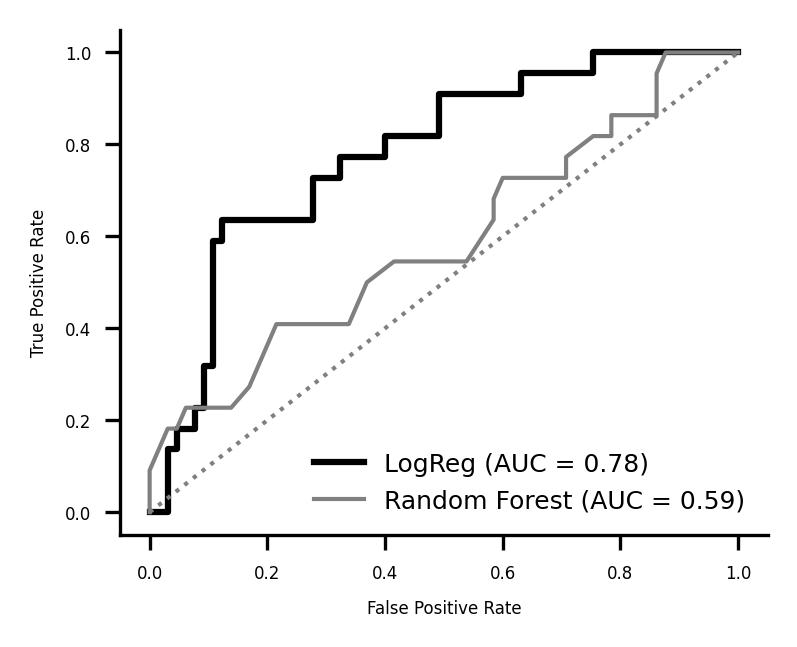

In [175]:
# -----------------------------
# Features & target definition
# -----------------------------
target = 'fast_learner'

practice_challenge_features = [
    'engagement__steady_magnitude', 'engagement__slope', 
    'engagement__early_slope', 'engagement__late_slope', 'engagement__mean', 'engagement__consistency',
    'spacing_weighted_mean_days_between_sessions__steady_magnitude', 'spacing_weighted_mean_days_between_sessions__slope', 
    'spacing_weighted_mean_days_between_sessions__early_slope', 'spacing_weighted_mean_days_between_sessions__late_slope', 
    'spacing_weighted_mean_days_between_sessions__mean','optimal_challenge__steady_magnitude', 'optimal_challenge__slope', 
    'optimal_challenge__early_slope', 'optimal_challenge__late_slope', 'optimal_challenge__mean']
    

entropy_efficiency_features = [
    'entropy_2gram__steady_magnitude', 'entropy_2gram__slope', 'entropy_2gram__early_slope', 
    'entropy_2gram__late_slope', 'entropy_2gram__mean', 'tactical__steady_magnitude', 'tactical__slope', 
    'tactical__early_slope', 'tactical__late_slope', 'tactical__mean']

all_features = practice_challenge_features + entropy_efficiency_features
available_features = [f for f in all_features if f in df.columns]

X = df[available_features]
y = df[target]

# -----------------------------
# Train/Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# -----------------------------
# Logistic Regression
# -----------------------------
logreg_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)
logreg_pipeline.fit(X_train, y_train)

# Feature importance: top 7
coefs = logreg_pipeline.named_steps['logisticregression'].coef_[0]
coef_series = pd.Series(coefs, index=X.columns)
top5_logreg_features = coef_series.abs().sort_values(ascending=False).head(5).index.tolist()

logreg_top5 = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)
logreg_top5.fit(X_train[top5_logreg_features], y_train)
y_pred_logreg = logreg_top5.predict(X_test[top5_logreg_features])
y_score_logreg = logreg_top5.predict_proba(X_test[top5_logreg_features])[:, 1]

report_logreg = classification_report(y_test, y_pred_logreg, output_dict=True)
roc_auc_logreg = roc_auc_score(y_test, y_score_logreg)

# -----------------------------
# Random Forest + SMOTE
# -----------------------------
rf_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_score_rf = rf_pipeline.predict_proba(X_test)[:, 1]

report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
roc_auc_rf = roc_auc_score(y_test, y_score_rf)

# -----------------------------
# Display Reports
# -----------------------------
print("📊 Logistic Regression (Top 5 Features):")
print(classification_report(y_test, y_pred_logreg))
print(f"ROC AUC: {roc_auc_logreg:.3f}")

print("\n🌲 Random Forest (SMOTE):")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC: {roc_auc_rf:.3f}")

# -----------------------------
# Summary Table
# -----------------------------
results_df = pd.DataFrame({
    'Logistic Regression (Top 5 Features)': {
        'Accuracy': report_logreg['accuracy'],
        'Precision': report_logreg['1']['precision'],
        'Recall': report_logreg['1']['recall'],
        'F1-Score': report_logreg['1']['f1-score'],
        'ROC AUC': roc_auc_logreg
    },
    'Random Forest (SMOTE)': {
        'Accuracy': report_rf['accuracy'],
        'Precision': report_rf['1']['precision'],
        'Recall': report_rf['1']['recall'],
        'F1-Score': report_rf['1']['f1-score'],
        'ROC AUC': roc_auc_rf
    }
}).T

print("\n📈 Summary:")
print(results_df.round(3))

# -----------------------------
# ROC Curve Plot
# -----------------------------


fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_score_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)

roc_auc_logreg = roc_auc_score(y_test, y_score_logreg)
roc_auc_rf = roc_auc_score(y_test, y_score_rf)

plt.rcParams.update({
    "font.size": 5,            # base
    "axes.labelsize": 7,       # axis labels
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6
})

fig, ax = plt.subplots(figsize=(2.5, 2.0), dpi=300)


ax.plot(fpr_logreg, tpr_logreg,
        label=f"LogReg (AUC = {roc_auc_logreg:.2f})",
        color="black", lw=1.5)
ax.plot(fpr_rf, tpr_rf,
        label=f"Random Forest (AUC = {roc_auc_rf:.2f})",
        color="gray", lw=1)
ax.plot([0, 1], [0, 1], linestyle=':', color='gray', lw=1)  # diagonal


ax.set_xlabel("False Positive Rate", fontsize=4)
ax.set_ylabel("True Positive Rate", fontsize=4)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=4)
ax.legend(frameon=False, fontsize=6, loc='lower right')

fig.tight_layout(pad=0.3)
plt.show()


# Plotting Feature Coefficients

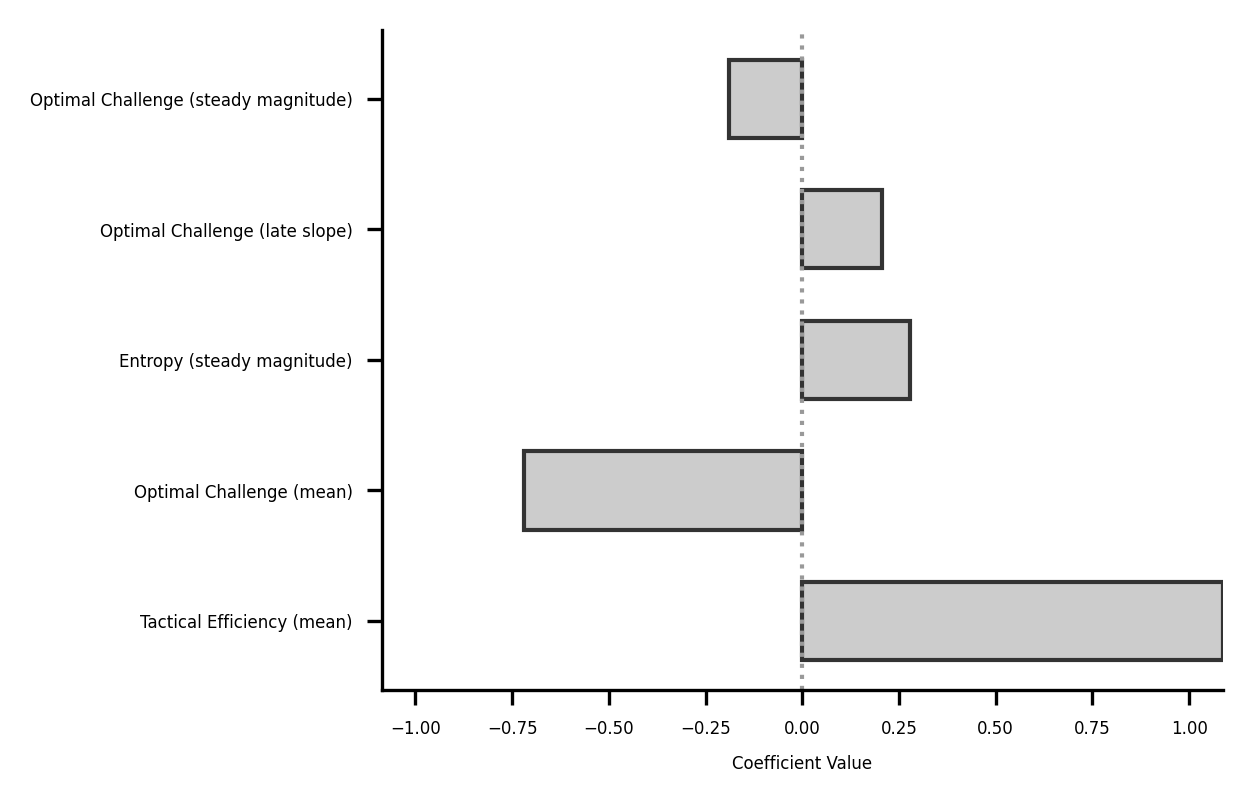

In [176]:

coefs = logreg_top5.named_steps['logisticregression'].coef_[0]
features = top5_logreg_features

coef_series = pd.Series(coefs, index=features)
coef_series = coef_series.reindex(coef_series.abs().sort_values(ascending=False).index)

name_map = {
    "optimal_challenge__steady_magnitude": "Optimal Challenge (steady magnitude)",
    "optimal_challenge__late_slope": "Optimal Challenge (late slope)",
    "entropy_2gram__steady_magnitude": "Entropy (steady magnitude)",
    "optimal_challenge__mean": "Optimal Challenge (mean)",
    "tactical__mean": "Tactical Efficiency (mean)"
}

coef_series.index = coef_series.index.map(lambda x: name_map.get(x, x))


plt.rcParams.update({
    "font.size": 3,
    "axes.labelsize": 3,
    "xtick.labelsize": 3,
    "ytick.labelsize": 3,
    "legend.fontsize": 3
})

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=300)


y = np.arange(len(coef_series))
vals = coef_series.values
ax.barh(y, vals, color="0.8", edgecolor="0.2", height=0.6)

max_abs = max(abs(coef_series.min()), abs(coef_series.max()))
ax.set_xlim(-max_abs, max_abs)


ax.set_yticks(y)
ax.set_yticklabels(coef_series.index)


ax.axvline(0, color="0.6", linestyle=":", linewidth=1)


ax.set_xlabel("Coefficient Value", fontsize = 4)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=4)

fig.tight_layout(pad=0.3)
plt.show()

## LINEAR REGRESSION

# Imports

In [198]:
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error


In [178]:
feature_list = ['engagement__steady_magnitude', 'engagement__slope', 
    'engagement__early_slope', 'engagement__late_slope', 'engagement__mean', 'engagement__consistency',
    'spacing_weighted_mean_days_between_sessions__steady_magnitude', 'spacing_weighted_mean_days_between_sessions__slope', 
    'spacing_weighted_mean_days_between_sessions__early_slope', 'spacing_weighted_mean_days_between_sessions__late_slope', 
    'spacing_weighted_mean_days_between_sessions__mean','optimal_challenge__steady_magnitude', 'optimal_challenge__slope', 
    'optimal_challenge__early_slope', 'optimal_challenge__late_slope', 'optimal_challenge__mean']

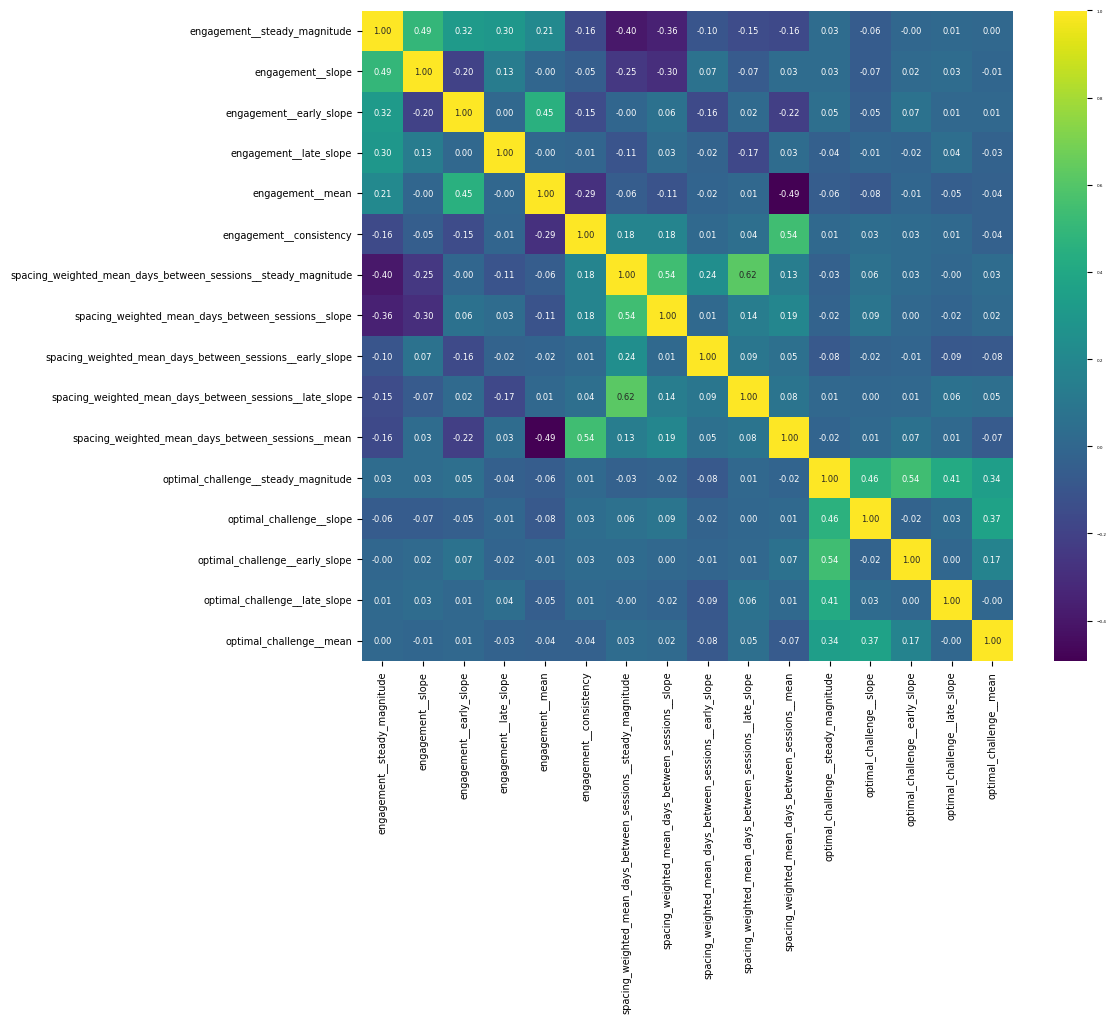

In [179]:
corr = df[feature_list].corr()

plt.figure(figsize=(12, 10))

sns.heatmap(
    corr, 
    annot=True, fmt=".2f", cmap="viridis", square=True,
    annot_kws={"size": 6}
)

plt.xticks(fontsize=7, rotation=90)  
plt.yticks(fontsize=7)              

plt.tight_layout()
plt.show()


In [180]:
reduced_features = ['engagement__steady_magnitude',
 'engagement__slope',
 'engagement__mean',
 'spacing_weighted_mean_days_between_sessions__steady_magnitude',
 'spacing_weighted_mean_days_between_sessions__slope',
 'spacing_weighted_mean_days_between_sessions__mean',
 'optimal_challenge__steady_magnitude',
 'optimal_challenge__slope',
 'optimal_challenge__mean']

                            OLS Regression Results                            
Dep. Variable:         tactical__mean   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     69.76
Date:                Fri, 12 Sep 2025   Prob (F-statistic):           6.66e-86
Time:                        15:32:04   Log-Likelihood:                 854.41
No. Observations:                 576   AIC:                            -1689.
Df Residuals:                     566   BIC:                            -1645.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

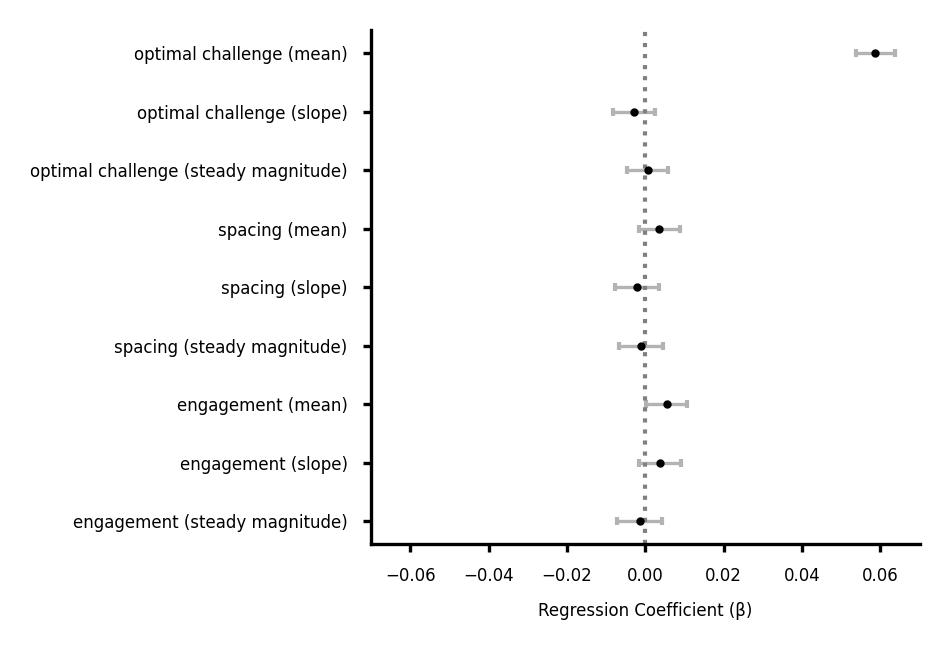

In [197]:
df_reduced = df.dropna(subset=reduced_features + ['tactical__mean'])
X = df_reduced[reduced_features]
y = df_reduced['tactical__mean']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
X_scaled_const = sm.add_constant(X_scaled)
model = sm.OLS(y, X_scaled_const).fit()
print(model.summary())


coefs = model.params.iloc[1:]             # skip intercept
conf  = model.conf_int().iloc[1:]         # skip intercept

coef      = coefs.values
ci_lower  = conf[0].values
ci_upper  = conf[1].values
err_low   = coef - ci_lower
err_high  = ci_upper - coef


pretty_labels = {'engagement__steady_magnitude' : 'engagement (steady magnitude)',
 'engagement__slope': 'engagement (slope)',
 'engagement__mean': 'engagement (mean)',
 'spacing_weighted_mean_days_between_sessions__steady_magnitude': 'spacing (steady magnitude)',
 'spacing_weighted_mean_days_between_sessions__slope': 'spacing (slope)',
 'spacing_weighted_mean_days_between_sessions__mean': 'spacing (mean)',
 'optimal_challenge__steady_magnitude': 'optimal challenge (steady magnitude)',
 'optimal_challenge__slope': 'optimal challenge (slope)',
 'optimal_challenge__mean': 'optimal challenge (mean)'
  }

predictors = [pretty_labels.get(c, c) for c in X.columns]  # same order/length as coef


plt.rcParams.update({
    "font.size": 4,
    "axes.labelsize": 7,
    "xtick.labelsize": 4,
    "ytick.labelsize": 4
})

fig, ax = plt.subplots(figsize=(3.0, 2.0), dpi=300)

ax.errorbar(
    coef, predictors,
    xerr=[err_low, err_high],
    fmt='o', color='black',
    ecolor='0.7', elinewidth=0.8, capsize=1, markersize=1
)

ax.axvline(0, linestyle=':', color='gray', lw=1)


max_abs = float(np.max(np.abs(np.r_[ci_lower, ci_upper, coef])))
ax.set_xlim(-1.1 * max_abs, 1.1 * max_abs)

ax.set_xlabel("Regression Coefficient (β)", fontsize=4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', length=2)

fig.tight_layout(pad=0.3)
plt.show()


In [199]:
y_pred = model.predict(X_scaled_const)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("RMSE:", rmse)

RMSE: 0.05489750676777938


In [182]:
import statsmodels.api as sm

# Fit model
X = sm.add_constant(X)  # if you didn't already add a constant
model = sm.OLS(y, X).fit()

In [183]:
import numpy as np

# Calculate residuals
residuals = model.resid

# RMSE
rmse = np.sqrt(np.mean(residuals ** 2))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.0549
